# 인물사진 모드 구현해보자!

### 필요한 패키지 import

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

### 이미지 로드

In [10]:
def image_load(img_name):
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'
    img_path = os.path.join(img_path, img_name)
    
    img_orig = cv2.imread(img_path) 
    
    return img_orig, img_path

(479, 720, 3)


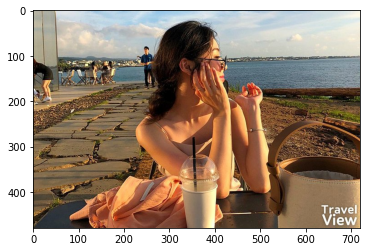

In [16]:
people_img_orig, people_img_path = image_load('people.jpg')

print(people_img_orig.shape)
plt.imshow(cv2.cvtColor(people_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 모델 불러오기 및 모델 정의
- 처음 1회만 해주면 된다!

In [8]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fa8b24c9580>)

In [53]:
# 모델 불러오기
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

### segmentAsPascalvoc 라벨의 종류!

In [27]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [28]:
people_segvalues, people_output = model.segmentAsPascalvoc(people_img_path)

In [29]:
people_segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

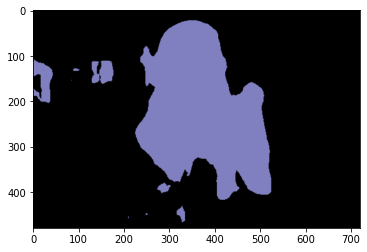

In [33]:
plt.imshow(people_output)
plt.show()

- 사람 사진은 backgroud(0), people(15) 사진이 분류가 되었다.

### segmentation이 잘되었나 확인하기
- output 색상 알아내기

In [44]:
# PixelLib에서 사용한 코드
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [47]:
# 사람
colormap[LABEL_NAMES.index('person')]

array([192, 128, 128])

In [49]:
# 고양이
colormap[LABEL_NAMES.index('cat')]

array([64,  0,  0])

### colormap은 RGB, outputBGR 순서이니 추출하는 색상 순서를 바꿔주어야한다.

In [50]:
people_seg_color = (128,128,192)

(479, 720)


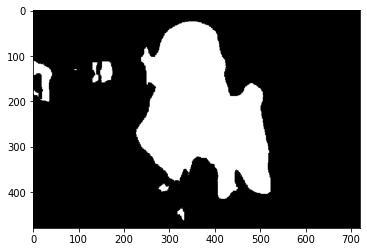

In [64]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
people_seg_map = np.all(people_output==people_seg_color, axis=-1)
print(people_seg_map.shape)
plt.imshow(people_seg_map, cmap='gray')
plt.show()

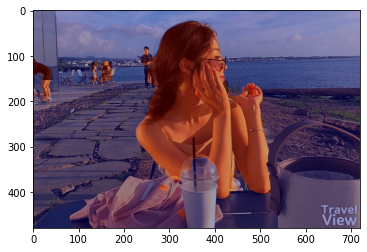

In [65]:
img_show = people_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 원본 이미지 블러하고, segmentation 마스크를 이용해 배경만 추출하기

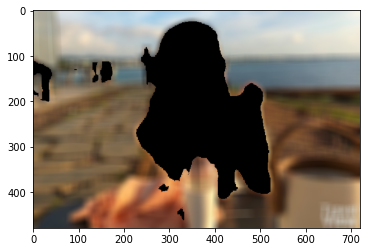

In [67]:
img_orig_blur = cv2.blur(people_img_orig, (20,20))

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

plt.show()

### 흐리게한 배경과 사람 합성하기

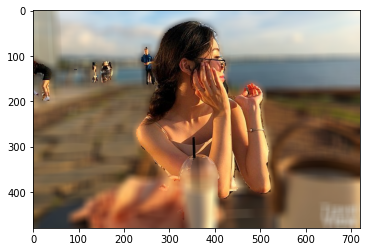

In [87]:
img_concat = np.where(img_mask_color==255, people_img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [90]:
cv2.imwrite(os.getenv('HOME')+'/aiffel/human_segmentation/images/blur_image.jpg', img_concat)

True

### 다른 배경과 합성하기

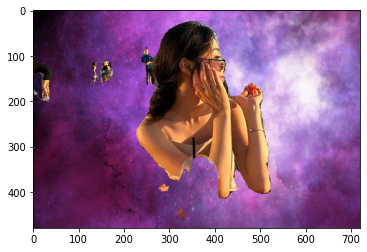

In [104]:
galaxy_img_orig, galaxy_img_path = image_load('galaxy.jpg')

# 합성할 사진과 배경 사진의 크기를 맞춰준다.
h = people_img_orig.shape[0]
w = people_img_orig.shape[1]

resize_galaxy_img_orig = cv2.resize(galaxy_img_orig, dsize=(w, h), interpolation=cv2.INTER_LINEAR)

crom_img_caoncat = np.where(img_mask_color == 255, people_img_orig, resize_galaxy_img_orig)

plt.imshow(cv2.cvtColor(crom_img_caoncat, cv2.COLOR_BGR2RGB))
plt.show()

In [105]:
cv2.imwrite(os.getenv('HOME')+'/aiffel/human_segmentation/images/blur_image.jpg', crom_img_caoncat)

True

### 고양이 합성하기!

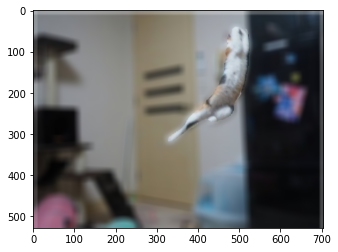

In [102]:
# 이미지 불러오기
cat_img_orig, cat_img_path = image_load('cat.jpg')

# segmentation 모델에 사진 적재
cat_segvalues, cat_output = model.segmentAsPascalvoc(cat_img_path)

# RGB 색상 바꾸기 RGB -> BGR
R = colormap[LABEL_NAMES.index('cat')][0]
G = colormap[LABEL_NAMES.index('cat')][1]
B = colormap[LABEL_NAMES.index('cat')][2]

cat_seg_color = (B, G, R)

# seg_map 생성
cat_seg_map = np.all(cat_output==cat_seg_color, axis=-1)

# img_mask 생성
cat_img_mask = cat_seg_map.astype(np.uint8) * 255

# 원본 이미지 블러
cat_img_orig_blur = cv2.blur(cat_img_orig, (20,20))

cat_img_mask_color = cv2.cvtColor(cat_img_mask, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)

# 이미지 합성
img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_orig_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 사진에서 문제점 찾기
- 실제 카메라로 하는 얕은 피사게 심도는 초점 대상을 기준으로 심도에 따라서 피사체와 배경을 나누게된다.
    - 심도가 좁다면 초점 대상만, 심도가 넓다면 전체적인 이미지
- 하지만 이번 실습에서 구현한 모델은 deeplabv3 모델을 통해서 피사체를 검출하고, 피사체 이외에 배경 화면을 조작하는 방식으로 진행하였다.

- 그러다보니 다음과같은 이미지의 문제점이 발견되었다.

![no_imgae](./EX7img/Inkedblur_image_LI.jpg)

- 이러한 문제점은 배경을 합성했을때 더 확실하게 캐치할수 있었고, 이미지도 어딘가 어색하다.

![no_imgae](./EX7img/crom_image.jpg)